# Low-Vol systematic trading strategy

The strategy aims at benefiting from the low-volatility anomaly, where the standard positive relationship between returns and volatility does not hold. The final portfolio invests in securities with the lowest annual volatility. The sample of stocks is divided into five quantiles based on the total volatility of the previous year and rebalanced monthly. 

In [1]:
import os
notebook_path = os.getcwd()
print(notebook_path)

/Users/stefanogrillini/Documents/Python/Coursera/EDHEC_Coursera_notebooks_and_codem01_v02/nb/My Strategies


In [2]:
path = "/Users/stefanogrillini/Documents/GitHub/Low-Vol-systematic-strategy/"
os.chdir(path)

In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
from datetime import date
import numpy as np
import yfinance as yf
import statsmodels.api as sm
import getFamaFrenchFactors as gff
import math
import hvplot.pandas
import holoviews as hv
from arch import arch_model
hv.extension('bokeh')
import my_risk_kit as erk

We fetch the names and Adjusted Closing Prices of the first 100 securities listed in the S&P 500 index as well as the benchmark.
Then we drop companies with missing data. 

In [4]:
sp500 = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
sp500_list = np.array(sp500[0]['Symbol'])

In [5]:
data = pd.DataFrame(columns = sp500_list[:100])
for i in data.columns:
    data[i] = yf.download(
    i, 
    start='2016-01-05', 
    end=date.today(),
    progress = False
)['Adj Close']

symbol_benchmark = "^SPX"
benchmark = yf.download(
    symbol_benchmark, 
    start='2016-01-05', 
    end=date.today()
)['Adj Close']


1 Failed download:
- BRK.B: No data found, symbol may be delisted

1 Failed download:
- BF.B: No data found for this date range, symbol may be delisted
[*********************100%***********************]  1 of 1 completed


In [6]:
for col in data:
   if data[col].isna().sum() > 0:
      print(col)

ABNB
BRK.B
BF.B
CARR


In [7]:
benchmark.isnull().values.any()

False

In [8]:
data.drop(['BRK.B','BF.B', 'CARR'], axis=1, inplace = True)
           
           
         #  , 'CDAY', 'CEG', 'CTVA', 'DOW', 'FTV'
         #  , 'FOXA', 'FOX', 'GEHC', 'HWM', 'IR', 'INVH', 'KVUE', 'LW'
         #  , 'MRNA', 'OGN', 'OTIS', 'VICI'], axis=1, inplace = True)

No we report some summary statistics and we compare the comulative performance of the S&P 500 Index vs a simple equally weighted average of the first 100 stocks.

In [9]:
# Some summary stats of the selected stocks
returns = data.pct_change().shift(1)
returns.dropna(inplace = True)
bench_ret = benchmark.pct_change().shift(1)
erk.summary_stats(returns, riskfree_rate=0.04/250, periods_per_year=250)

Annualized Return  Annualized Vol  Skewness  Kurtosis  \
MMM           -0.141686        0.244999 -0.021666  7.632306   
AOS            0.084399        0.293466  0.986375  8.845758   
ABT           -0.002495        0.228015 -0.208697  7.242291   
ABBV           0.185851        0.209698 -0.900426  7.792368   
ACN            0.108691        0.263220  0.174302  5.231323   
...                 ...             ...       ...       ...   
CBOE           0.221704        0.238769  0.117138  4.890542   
CBRE           0.064559        0.300243  0.168432  4.971786   
CDW            0.193145        0.273235 -0.514171  8.813844   
CE             0.015983        0.334648  0.344987  6.096351   
COR            0.252058        0.219164  0.069547  6.294822   

      Cornish-Fisher VaR (5%)  Historic CVaR (5%)  Sharpe Ratio  Max Drawdown  
MMM                  0.024607            0.035829     -0.578876     -0.506738  
AOS                  0.022286            0.037123      0.287003     -0.426842  
ABT                  0.023219            0.031933     -0.011643     -0.316732  
ABBV                 0.022937            0.031613      0.885373     -0.219155  
ACN                  0.025229            0.037092      0.412253     -0.396878  
...                       ...                 ...           ...           ...  
CBOE                 0.022824            0.031658      0.927712     -0.223810  
CBRE                 0.029108            0.041545      0.214456     -0.387942  
CDW                  0.027960            0.038993      0.706183     -0.260391  
CE                   0.031059            0.045508      0.047276     -0.486814  
COR                  0.020592            0.030543      1.149171     -0.178396  

[97 rows x 8 columns]

In [10]:
# Let's start with a simple equally-weighted portfolio
ew_average = returns.mean(axis=1)
ew_portfolio = pd.DataFrame({'SP500': bench_ret, 'Equally-weighted average': ew_average}, index = returns.index)
ew_portfolio.isnull().values.any()

False

In [11]:
ew_portfolio.corr()

SP500  Equally-weighted average
SP500                     1.000000                  0.960123
Equally-weighted average  0.960123                  1.000000

Annualized Return  Annualized Vol  Skewness  \
SP500                              0.072286        0.178491 -0.136934   
Equally-weighted average           0.104096        0.184647 -0.023773   

                          Kurtosis  Cornish-Fisher VaR (5%)  \
SP500                     4.603929                 0.018282   
Equally-weighted average  4.724538                 0.018403   

                          Historic CVaR (5%)  Sharpe Ratio  Max Drawdown  
SP500                               0.026007      0.173938     -0.254251  
Equally-weighted average            0.026339      0.333814     -0.225266

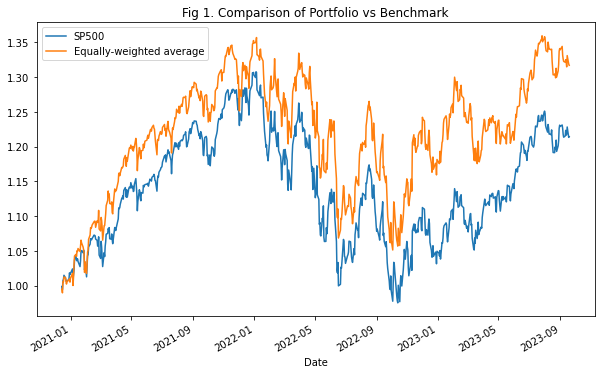

In [12]:
(1+ew_portfolio).cumprod().plot(figsize=(10,6), title="Fig 1. Comparison of Portfolio vs Benchmark")
erk.summary_stats(ew_portfolio.dropna(), riskfree_rate=0.04, periods_per_year=250)

Overall, a simple portfolio with equally weighted returns for the first 100 stocks of the S&P 500 Index yields better performances. In the literature this is explained by the overweight that some stocks have in the index such that its performances are mainly driven by the performances of the top contributors. 

In [13]:
# Convert from daily to monthly prices using 'M'
data_monthly = data.resample('M').last()

# Drop the columns with insufficient data
data_monthly_clean = data_monthly.dropna(axis=1)

In [14]:
data_monthly_clean.head()

MMM        AOS        ABT       ABBV         ACN  \
Date                                                                  
2016-01-31  116.267052  30.848152  32.970325  39.661049   93.252815   
2016-02-29  121.659546  31.192017  33.745583  39.451557   88.587502   
2016-03-31  129.228851  33.820156  36.437210  41.264828  101.964905   
2016-04-30  129.810516  34.326408  34.091942  44.491287  100.742386   
2016-05-31  131.408783  36.584610  34.731724  45.898952  106.139915   

                 ATVI        ADM       ADBE        ADP       AES  ...  \
Date                                                              ...   
2016-01-31  32.943645  28.415325  89.129997  70.415245  7.392311  ...   
2016-02-29  29.963388  28.358234  85.150002  71.771179  7.625752  ...   
2016-03-31  32.276989  29.453304  93.800003  76.499672  9.182030  ...   
2016-04-30  32.877892  32.397827  94.220001  75.416702  8.768782  ...   
2016-05-31  37.446648  34.972221  99.470001  74.905075  8.713778  ...   

                  CAH        KMX        CCL       CTLT        CAT       CBOE  \
Date                                                                           
2016-01-31  63.826946  44.180000  42.007370  23.530001  51.135284  64.219368   
2016-02-29  64.085800  46.259998  42.139801  24.270000  55.621117  60.247841   
2016-03-31  64.587402  51.099998  46.366081  26.670000  62.883904  63.205479   
2016-04-30  61.836819  52.950001  43.097527  29.530001  64.475967  59.945076   
2016-05-31  62.223007  53.660000  42.237335  28.120001  60.153790  61.580116   

                 CBRE        CDW         CE        COR  
Date                                                    
2016-01-31  27.969999  35.204681  53.964760  79.067085  
2016-02-29  25.410000  36.340027  51.413246  76.769913  
2016-03-31  28.820000  38.102856  55.809860  76.707878  
2016-04-30  29.629999  35.348434  60.545422  75.422752  
2016-05-31  29.850000  39.175209  60.357006  66.755577  

[5 rows x 96 columns]

## Build Low Vol indicator and loop across all dates

In [15]:
monthly_returns = data_monthly_clean.pct_change().shift(1)
monthly_returns = monthly_returns.dropna(axis=0)

<AxesSubplot:xlabel='Date'>

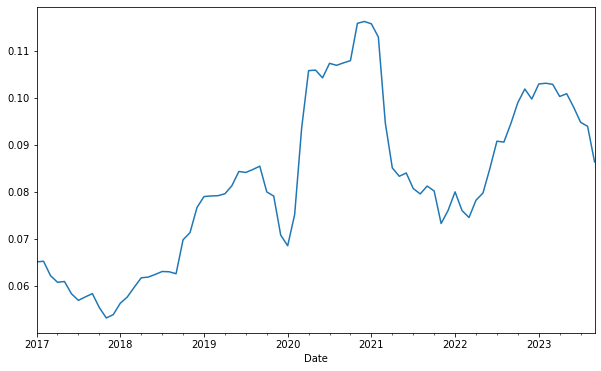

In [16]:
# 1st Signal: Low Vol indicator
vol_12 = data_monthly_clean.pct_change().rolling(window=12).std()
# Drop the 1 or 2 rows with NA's
vol_12 = vol_12.dropna(axis=0)
vol_12.mean(axis = 1).plot(figsize = (10,6))

<AxesSubplot:xlabel='Date'>

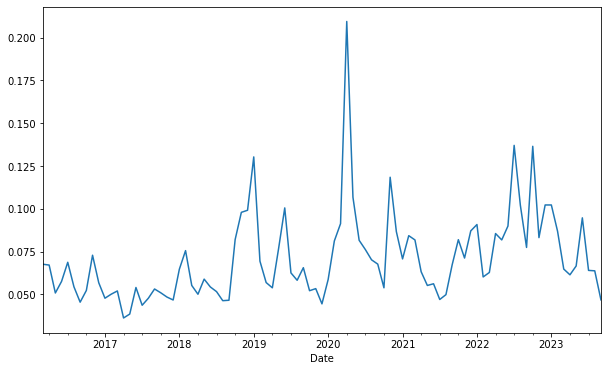

In [17]:
# 2nd Signal: Low Vol indicator using EWMA, with decay factor alpha = 0.94
vol_ewma = data_monthly_clean.pct_change().ewm(alpha = 0.9, adjust = True).std()
# Drop the 1 or 2 rows with NA's
vol_ewma = vol_ewma.dropna(axis=0)
vol_ewma.mean(axis = 1).plot(figsize = (10,6))

In [18]:
# Create a df for volatility ranks
vol_ranks = pd.DataFrame(index=vol_12.index, columns=vol_12.columns)
vol_ranks_ewma = pd.DataFrame(index=vol_ewma.index, columns=vol_12.columns)

In [19]:
# Place each stock in a "quintile" bucket, at each "date" (rows) for simple volatility
for date in vol_ranks.index:
    row_values = vol_12.loc[date] # looping values each row
    ranks = pd.Series(row_values).rank(method='max') # set rank at each row
    quintiles = pd.qcut(ranks, q=5, labels=False) # divide into quintiles

    # Create dataframe with ranks for each stock at each month(4=high, 0=low)
    vol_ranks.loc[date] = quintiles 

In [20]:
# Place each stock in a "quintile" bucket, at each "date" (rows) for ewma volatility
for date in vol_ranks_ewma.index:
    row_values = vol_ewma.loc[date] # looping values each row
    ranks = pd.Series(row_values).rank(method='max') # set rank at each row
    quintiles = pd.qcut(ranks, q=5, labels=False) # divide into quintiles

    # Create dataframe with ranks for each stock at each month(4=high, 0=low)
    vol_ranks_ewma.loc[date] = quintiles 

In [21]:
quintile_dfs = {}
vol_returns = pd.DataFrame()

# Iterate for each quintile, and form portfolios accordingly
for quintile in range(5):
    
    # Only take returns if they're in quintile associated with the current loop.
    filtered_df = monthly_returns[vol_ranks == quintile]
    
    # shift to "t+1" return as rank at time "t" corresponds to return at time "t+1"
    filtered_df_shifted = filtered_df.shift(-1).dropna(how='all',axis=0)

    # Put those returns into dictionary "quintile_dfs"
    quintile_dfs[quintile] = filtered_df_shifted

    #For Equal-Weight, simply take the average return across stocks within each quintile dataframe
    vol_returns[quintile] = quintile_dfs[quintile].mean(axis=1).dropna()

In [22]:
quintile_dfs_ewma = {}
vol_returns_ewma = pd.DataFrame()

# Iterate for each quintile, and form portfolios accordingly
for quintile in range(5):
    
    # Only take returns if they're in quintile associated with the current loop.
    filtered_df = monthly_returns[vol_ranks_ewma == quintile]
    
    # shift to "t+1" return as rank at time "t" corresponds to return at time "t+1"
    filtered_df_shifted = filtered_df.shift(-1).dropna(how='all',axis=0)

    # Put those returns into dictionary "quintile_dfs"
    quintile_dfs_ewma[quintile] = filtered_df_shifted

    #For Equal-Weight, simply take the average return across stocks within each quintile dataframe
    vol_returns_ewma[quintile] = quintile_dfs_ewma[quintile].mean(axis=1).dropna()

In [39]:
vol_returns.rename(columns = {0: 'Very Low Vol', 1: 'Low Vol', 2: 'Medium', 3: 'High Vol', 4: 'Very High Vol'}, inplace = True)
vol_returns.describe()

Very Low Vol    Low Vol     Medium   High Vol  Very High Vol
count     81.000000  81.000000  81.000000  81.000000      81.000000
mean       0.012074   0.013701   0.011815   0.012746       0.019424
std        0.030297   0.041577   0.050338   0.061875       0.096421
min       -0.074844  -0.102973  -0.113523  -0.160246      -0.379117
25%       -0.001550  -0.005312  -0.015622  -0.019777      -0.013577
50%        0.015646   0.016293   0.013784   0.022325       0.023366
75%        0.033426   0.037547   0.043193   0.052633       0.054764
max        0.076310   0.109173   0.128945   0.162563       0.300104

In [40]:
vol_returns_ewma.rename(columns = {0: 'Very Low Vol', 1: 'Low Vol', 2: 'Medium', 3: 'High Vol', 4: 'Very High Vol'}, inplace = True)
vol_returns_ewma.describe()

Very Low Vol    Low Vol     Medium   High Vol  Very High Vol
count     90.000000  90.000000  90.000000  90.000000      90.000000
mean       0.009031   0.010177   0.014687   0.016202       0.025022
std        0.024948   0.037067   0.048127   0.061033       0.106165
min       -0.074261  -0.100084  -0.113895  -0.192489      -0.390587
25%       -0.003085  -0.012318  -0.005257  -0.013068      -0.028847
50%        0.013589   0.015705   0.016406   0.021285       0.034168
75%        0.024859   0.029905   0.043487   0.050626       0.087936
max        0.056852   0.095429   0.124999   0.134429       0.326843

Annualized Return  Annualized Vol  Skewness  Kurtosis  \
Very Low Vol            0.148692        0.104951 -0.699616  3.670409   
Low Vol                 0.165533        0.144028 -0.467850  3.133939   
Medium                  0.134369        0.174378 -0.310640  3.038905   
High Vol                0.138031        0.214340 -0.470255  3.258118   
Very High Vol           0.190334        0.334012 -0.504748  6.702575   

               Cornish-Fisher VaR (5%)  Historic CVaR (5%)  Sharpe Ratio  \
Very Low Vol                  0.042755            0.061178      0.999033   
Low Vol                       0.059477            0.077623      0.840698   
Medium                        0.074759            0.096856      0.521829   
High Vol                      0.096043            0.124134      0.440885   
Very High Vol                 0.144323            0.200152      0.433589   

               Max Drawdown  
Very Low Vol      -0.123801  
Low Vol           -0.174729  
Medium            -0.229380  
High Vol          -0.320912  
Very High Vol     -0.463016

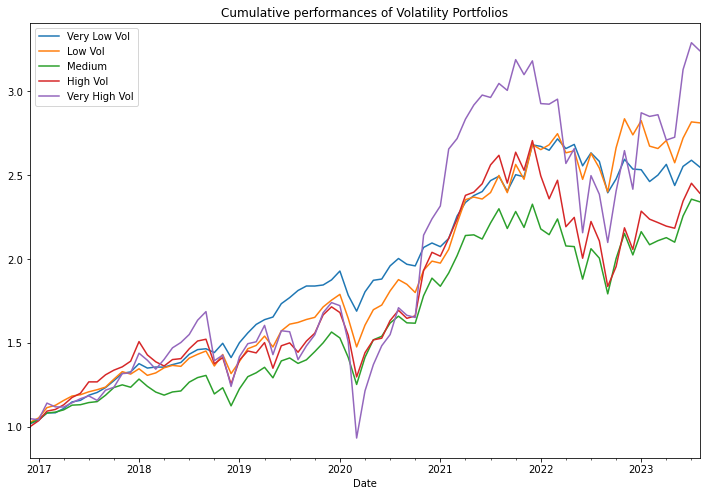

In [25]:
# Plot the cumulative return
(1+vol_returns).cumprod().plot(figsize = (12, 8), title = "Cumulative performances of Volatility Portfolios")
erk.summary_stats(vol_returns, riskfree_rate=0.04, periods_per_year=12)

Annualized Return  Annualized Vol  Skewness  Kurtosis  \
Very Low Vol               0.110           0.086    -0.982     4.201   
Low Vol                    0.120           0.128    -0.463     3.774   
Medium                     0.175           0.167    -0.480     3.393   
High Vol                   0.186           0.211    -0.616     3.807   
Very High Vol              0.257           0.368    -0.496     5.272   

               Cornish-Fisher VaR (5%)  Historic CVaR (5%)  Sharpe Ratio  \
Very Low Vol                     0.038               0.055         0.779   
Low Vol                          0.055               0.080         0.602   
Medium                           0.070               0.098         0.782   
High Vol                         0.093               0.125         0.667   
Very High Vol                    0.158               0.220         0.568   

               Max Drawdown  
Very Low Vol         -0.182  
Low Vol              -0.232  
Medium               -0.210  
High Vol             -0.256  
Very High Vol        -0.449

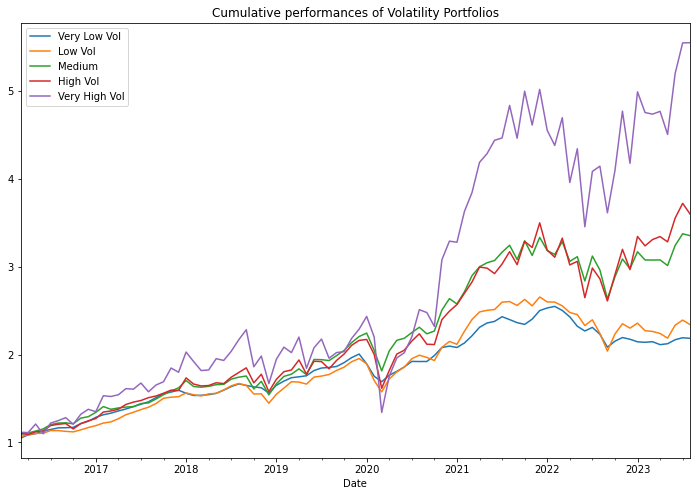

In [36]:
# Plot the cumulative return
(1+vol_returns_ewma).cumprod().plot(figsize = (12, 8), title = "Cumulative performances of Volatility Portfolios")
round(erk.summary_stats(vol_returns_ewma, riskfree_rate=0.04, periods_per_year=12), 3)

In [27]:
# Convert from daily to monthly also the SP500
bench_monthly = benchmark.resample('M').last()
bench_ret_monthly = bench_monthly.pct_change()
bench_ret_monthly.isnull().values.any()

True

In [28]:
vol_ranks.columns[vol_ranks.iloc[-1] == 4]

Index(['ALK', 'ALB', 'ALGN', 'AMD', 'AAL', 'APA', 'AMAT', 'APTV', 'ANET',
       'AXON', 'BKR', 'BX', 'BA', 'BXP', 'CZR', 'COF', 'CCL', 'CTLT', 'CAT'],
      dtype='object')

In [29]:
bench_ret_monthly.dropna(inplace = True)

In [37]:
low_vol_df = pd.DataFrame({'SP500': bench_ret_monthly, 'Low Vol std': vol_returns['Very Low Vol'], 'Low Vol ewma': vol_returns_ewma['Very Low Vol']}, index = vol_returns.index)
low_vol_df.dropna(inplace = True)

In [38]:
low_vol_df.describe()

SP500  Low Vol std  Low Vol ewma
count  81.000000    81.000000     81.000000
mean    0.010039     0.012074      0.007603
std     0.047773     0.030297      0.025421
min    -0.125119    -0.074844     -0.074261
25%    -0.011137    -0.001550     -0.007605
50%     0.017924     0.015646      0.012781
75%     0.036022     0.033426      0.023619
max     0.126844     0.076310      0.056852

Annualized Return  Annualized Vol  Skewness  Kurtosis  \
SP500                       0.112211        0.165490 -0.496735  3.398506   
Low Vol Portfolio           0.148692        0.104951 -0.699616  3.670409   

                   Cornish-Fisher VaR (5%)  Historic CVaR (5%)  Sharpe Ratio  \
SP500                             0.074156            0.096472      0.420688   
Low Vol Portfolio                 0.042755            0.061178      0.999033   

                   Max Drawdown  
SP500                 -0.247695  
Low Vol Portfolio     -0.123801

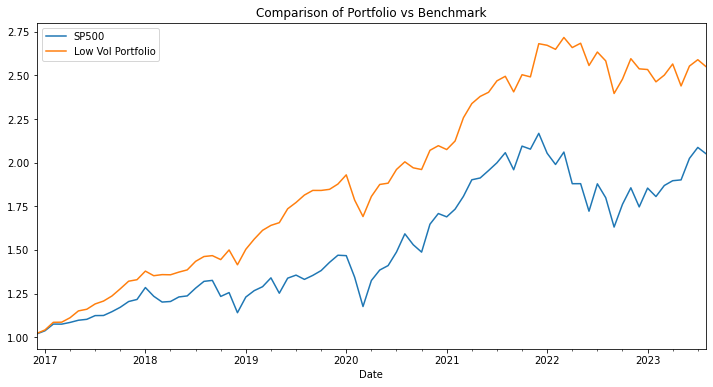

In [32]:
(1+low_vol_df).cumprod().plot(figsize=(12,6), title="Comparison of Portfolio vs Benchmark")
erk.summary_stats(low_vol_df.dropna(), riskfree_rate=0.04, periods_per_year=12)

The momentum signal for the portfolio improves the performances, with 30% annualized returns vs 5.8%, SR>1, lower drawdown and lower VaR. However, there is higher volatility. Next step is to make the portofolio market neutral. 

# Test the portfolio vs Fama - French 3 factor model + Carhart momentum

In [33]:
ff4 = gff.carhart4Factor(frequency = 'm')
ff4.rename(columns = {'date_ff_factors': 'Date'}, inplace = True)
ff4.set_index('Date', inplace = True)
ff4 = ff4['2016-05-01':]
ff4.head()

Mkt-RF     SMB     HML      RF     MOM
Date                                              
2016-05-31  0.0178 -0.0017 -0.0166  0.0001  0.0142
2016-06-30 -0.0005  0.0061 -0.0148  0.0002  0.0413
2016-07-31  0.0395  0.0249 -0.0132  0.0002 -0.0334
2016-08-31  0.0049  0.0115  0.0318  0.0002 -0.0349
2016-09-30  0.0025  0.0212 -0.0124  0.0002  0.0019

In [34]:
ff_test = pd.concat([low_vol_df['Low Vol Portfolio'], ff4], axis=1)
monthly_returns
ff_test.dropna(axis = 0, inplace = True)

In [35]:
y, x = ff_test[['Low Vol Portfolio']], ff_test[['Mkt-RF', 'SMB', 'HML', 'MOM']]
x = sm.add_constant(x) 
est = sm.OLS(y, x).fit() 
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      Low Vol Portfolio   R-squared:                       0.754
Model:                            OLS   Adj. R-squared:                  0.741
Method:                 Least Squares   F-statistic:                     57.47
Date:                Wed, 20 Sep 2023   Prob (F-statistic):           4.24e-22
Time:                        11:33:18   Log-Likelihood:                 222.74
No. Observations:                  80   AIC:                            -435.5
Df Residuals:                      75   BIC:                            -423.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0067      0.002      3.752      0.000       0.003       0.010
Mkt-RF         0.5589      0.040     14.041      0.000       0.480       0.638
SMB           -0.3178      0.069     -4.602      0.000      -0.455      -0.180
HML            0.1134      0.043      2.649      0.010       0.028       0.199
MOM            0.0649      0.051      1.278      0.205      -0.036       0.166
==============================================================================
Omnibus:                        2.573   Durbin-Watson:                   2.036
Prob(Omnibus):                  0.276   Jarque-Bera (JB):                2.184
Skew:                           0.082   Prob(JB):                        0.336
Kurtosis:                       3.793   Cond. No.                         41.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""